This notebook implements a simple linear tracking controller based on optimal control theory. Given the dynamical system
$$
\frac{d}{dt}\vec{x} = \mathbf{A} \vec{x} + \mathbf{B} \vec{u},
$$
and the goal of making $\vec{x}(t)$ follow a target trajectory $\vec{r}(t)$ while minimizing $|\vec{u}(t)|^2$, according to the following cost function:
$$
g(\vec{x}(t), \vec{u}(t)) = \frac{1}{2} |\vec{x}(t) - \vec{r}(t)|^2 + \frac{\lambda}{2} |\vec{u}(t)|^2.
$$
This notebook finds the optimal-control trajectory $\vec{u}(t)$ and the corresponding trajectory $\vec{x}(t)$.


In class, we used calculus of variations to show that we can solve this problem by solving the following sets of equations.

First, we need to integrate the following equations _backward_ in time, starting from the initial conditions $\vec{s}(T) = 0$ and $\mathbf{K}(T) = 0$:
$$
\dot{\vec{s}} = \left( \frac{1}{\lambda} \mathbf{KBB}^\top - \mathbf{A}^\top \right) \vec{s} + \vec{r}, \\
\dot{\mathbf{K}} = - \mathbb{I} - \mathbf{A}^\top \mathbf{K} - \mathbf{KA} + \frac{1}{\lambda} \mathbf{KBB}^\top \mathbf{K}.
$$
After obtaining these, we use them to integrate the following equations forward in time starting from a given initial condition $\vec{x}(0)$:
$$
\vec{u} = -\frac{1}{\lambda} \mathbf{B}^\top [\mathbf{K}\vec{x} + \vec{s}], \\
\dot{\vec{x}} = \mathbf{A} \vec{x} + \mathbf{B} \vec{u}.
$$

Let's start by defining some parameters and the trajectory we'd like $\vec{x}(t)$ to follow:

Text(0, 0.5, 'r')

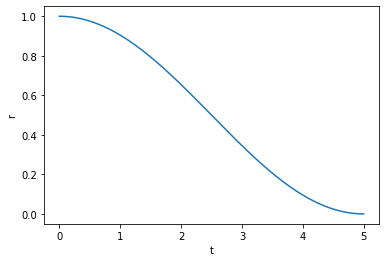

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 5  # time duration
dt = 0.01  # size of timestep for numerical integration
n_t = round(T/dt)  # number of timesteps
t_range = np.linspace(0, T, n_t)

# The matrices that specify our linear dynamical system:
A = np.array([[0, 1], [0, 0]])  
B = np.reshape(np.array([0, 1]), (2,1))

# The target trajectory:
r = np.zeros((n_t, 2))
r[:,0] = 0.5 * (1 + np.cos(2 * np.pi * t_range / (2 * T)))
r[:,1] = - 0.5 * np.pi / T * np.sin(2 * np.pi * t_range / (2 * T))

# Plot the trajectory that we want x(t) to follow.
plt.plot(t_range, r[:,0])
plt.xlabel('t')
plt.ylabel('r')

**Exercise**: Complete the following function with four lines of code that implement Euler integration for the four differential equations given above.

In [3]:
## Solution ##

# A function that computes x(t) and u(t) given lambda:
def control(lam):
    # Initialize arrays:
    s = np.zeros((n_t, 2))
    K = np.zeros((n_t, 2, 2))
    x = np.zeros((n_t, 2))
    u = np.zeros((n_t, 1))

    # Initial conditions for the dynamical system:
    x[0, 0] = 1  # initial position
    x[0, 1] = 0  # initial velocity

    # Integrate backward in time to get s and K:
    for t in np.arange(1, n_t)[::-1]:
        s[t-1,:] = s[t,:] - dt * \
            ((np.linalg.multi_dot([K[t,:,:], B, B.T]) 
              / lam - A.T) @ s[t,:] + r[t,:])
        K[t-1,:,:] = K[t,:,:] - \
            dt * (-np.eye(2) 
                  - A.T @ K[t,:,:] - K[t,:,:] @ A 
                  + np.linalg.multi_dot([K[t,:,:], B, B.T, K[t,:,:]]) 
                  / lam)

    # Integrate the dynamical system forward in time given 
    # the optimal control to get u and x:
    for t in np.arange(n_t-1):
        u[t,:] = -1 / lam * B.T @ (K[t,:,:] @ x[t,:] + s[t,:])
        x[t+1,:] = x[t,:] + dt * (A @ x[t,:] + B @ u[t,:])
        
    return u, x

**Exercise**: Using the above function, plot the solution $x_1(t)$ for the values $\lambda = 0.1, 1, 10, 100$. In a separate subplot, plot the corresponding control signal $u(t)$ for each value of $\lambda$. What do you notice about the solutions?

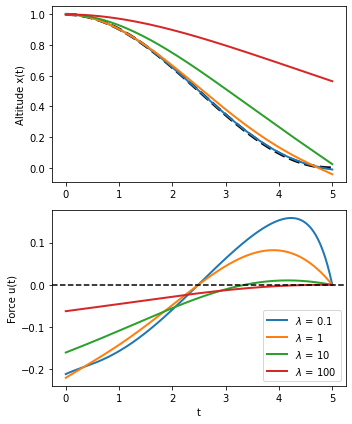

In [4]:
## Solution ##

plt.figure(figsize=(5,6))

plt.subplot(211)
plt.plot(t_range, r[:,0], '--k', lw=3)
plt.ylabel('Altitude x(t)')

lam_list = [0.1, 1, 10, 100]
u_list, x_list = [], []
for lam in lam_list:
    u, x = control(lam)
    plt.subplot(211)
    plt.plot(t_range, x[:,0], lw=2)
    plt.subplot(212)
    plt.plot(t_range, u, lw=2)
    
plt.axhline(0, ls='--', color='k')
plt.xlabel('t')
plt.ylabel('Force u(t)')
plt.legend(['$\lambda$ = ' + str(lam) for lam in lam_list], loc=4)
plt.tight_layout()